In [157]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [158]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [159]:
## 평가모듈
import evaluation_module as evm

## Data

In [160]:
df_ori = pd.read_csv('data/data_prep.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

In [161]:
ML_res = pd.read_csv('data/result_ML.csv')
ML_res['time'] = pd.to_datetime(ML_res['time'])
ML_res = ML_res.set_index('time')

In [162]:
dataset = df_ori.copy()
dataset['hat'] = ML_res['hat'].dropna()
dataset = dataset.dropna()

dataset['spread_ratio'] = dataset['spread']/dataset['vwap_near']

In [163]:
## 역사적 스프레드비율
temp = dataset.drop_duplicates(subset='epi_no', keep='last')
cri_min = temp['spread_ratio'].min()
cri_max = temp['spread_ratio'].max()

In [164]:
## Test index
test_split = df_ori[df_ori['epi_no'] > 8].index[0]
test_split

Timestamp('2019-12-27 12:00:00')

In [197]:
## 룰베이스 BM용
cri_ustd = dataset['spread_ratio'][:test_split].quantile(0.75)
cri_lstd = dataset['spread_ratio'][:test_split].quantile(0.25)

## 전략구현

* 전략 리스트  
  - ML: 스프레드매수매도 기회를 모두 활용하는 전략
  - ML_v2: 역사적 스프레드비율 외구간에서만 매수매도 기회를 활용하는 전략
  - Rule: 스프레드비율 1표준편차 외구간에서 매수매도하는 전략
* Bench Mark  
  - 당분기 선물 Buy&Hold

* ML전략 구현  
  - 예측 스프레드가 현재 스프레드보다 낮을 때는 스프레드 매도포지션
  - 예측 스프레드가 현재 스프레드보다 높을 때는 스프레드 매수포지션
  - 당분기물 만기시점에는 중립
  - pre_pos: 전기 포지션 => 전기 표지션을 통해서 현재 얻은 수익을 산출하기 위함
* 주의사항: 거래비용은 고려하지 않음

* Rule 전략 구현  
  - 스프레드 비율(Spread/당분기물가격) 3/4분위수 초과시 매도
  - 1/4분위수 미만시 매수
  - 당분기물 만기시점에는 중립
  - 스프레드 비율의 평균회귀 성향을 활용한 전략

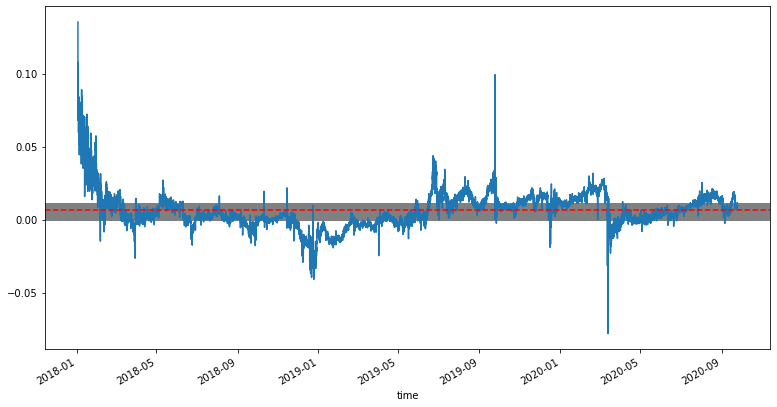

In [198]:
## Rule 전략 시각화
dataset['spread_ratio'].plot()
plt.axhline(dataset['spread_ratio'].mean(), color='r', linestyle='--')
plt.axhspan(cri_ustd, cri_lstd, facecolor='gray')

In [199]:
dataset['pre_pos'] = 0
dataset['pre_pos'][dataset['hat'].shift(-1) > dataset['spread']] = 1
dataset['pre_pos'][dataset['hat'].shift(-1) < dataset['spread']] = -1
dataset['pre_pos'][dataset['duetime'] == 0] = 0
dataset['pre_pos'] = dataset['pre_pos'].shift(1)

In [200]:
dataset['pre_pos_Rule'] = 0
dataset['pre_pos_Rule'][dataset['spread_ratio'] > cri_ustd] = -1
dataset['pre_pos_Rule'][dataset['spread_ratio'] < cri_lstd] = 1
dataset['pre_pos'][dataset['duetime'] == 0] = 0
dataset['pre_pos_Rule'] = dataset['pre_pos_Rule'].shift(1)

In [201]:
## 항상 매수포지션일 때의 수익률
## 스프레드차익/(매수증거금+매도증거금)
dataset['rets'] = ((dataset['spread'] - dataset['spread'].shift(1))/
                   (dataset['vwap_near']+dataset['vwap_longer']).shift(1))

In [202]:
## 예측모형을 활용한 양측 매매 전략
dataset['ML'] = dataset['rets'] * dataset['pre_pos']

## 역사적 스프레드 비율을 임계점으로 활용하는 전략
dataset['ML_v2'] = dataset['ML'].copy()
dataset['ML_v2'][(dataset['spread_ratio'].shift(1) <= cri_max)&(dataset['spread_ratio'].shift(1) >= cri_min)] = 0

## Rule_p1 Spread 비율이 2표준편차를 초과할때만 매도매수
dataset['Rule'] = dataset['rets'] * dataset['pre_pos_Rule']

## BM1: 당분기물 Buy&Hold 롤오버는 고려하지 않음
dataset['BM1'] = dataset['vwap_near'].pct_change()

## 전략 평가

In [203]:
df_rets = dataset[['ML', 'ML_v2', 'Rule', 'BM1']].dropna()

### 평가 요약

In [204]:
report = evm.get_report2(df_rets, term='bit')
print('전체기간 성능평가')
report
## 분석 초기 과도한 스프레드가 과대 Return으로 나타남
## Trainset이 포함되었으므로 모델 적합만 파악함

전체기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML,0.4250,0.1155,3.6804,-0.1191,0.5085
ML_v2,0.2327,0.0787,2.9560,-0.0781,0.9576
Rule,0.5328,0.0990,5.3826,-0.0384,0.7731
BM1,-0.1589,0.7478,-0.2126,-0.8326,0.5131


In [205]:
report_l3 = evm.get_report2(df_rets[test_split:], term='bit')
print('최근 3분기(Test기간) 성능평가')
report_l3

최근 3분기(Test기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML,0.1911,0.0942,2.0285,-0.0802,0.5027
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
Rule,0.4562,0.0731,6.2416,-0.0131,0.7767
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


### 자산가치 추이

<AxesSubplot:xlabel='time'>

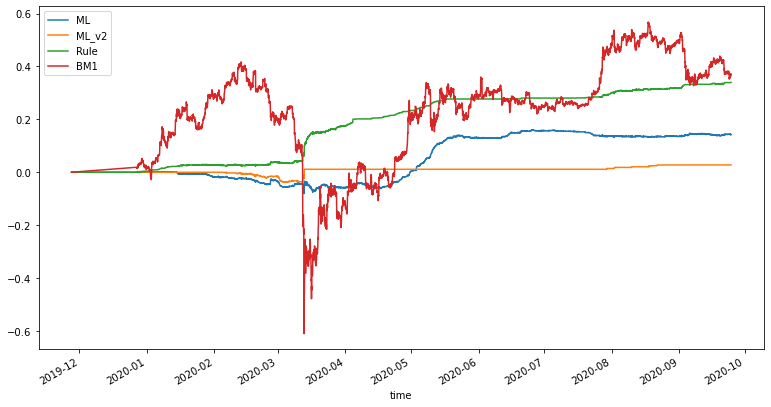

In [206]:
df_value_L3 = evm.get_df_val(df_rets[test_split:])
## Test기간
np.log(df_value_L3).plot()

### MDD

In [207]:
df_dd = evm.get_dd(df_value_L3)

<AxesSubplot:xlabel='time'>

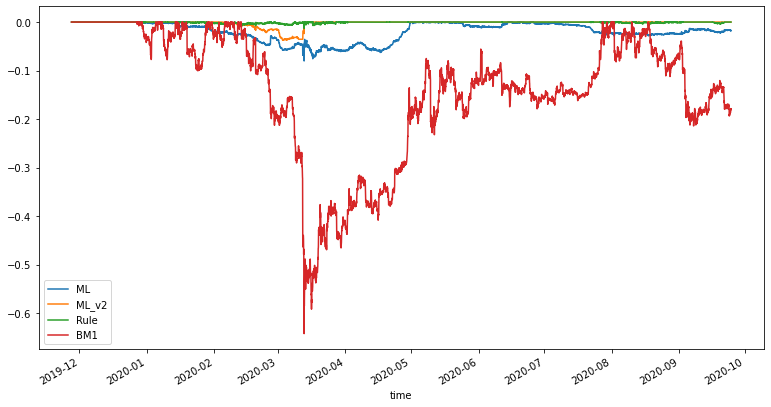

In [208]:
df_dd.plot()

### Turn Over

In [222]:
temp = dataset[test_split:].copy()

TO_ML = len(temp[(temp['pre_pos_Rule'].shift() != temp['pre_pos_Rule'])])
TO_Rule = len(temp[(temp['pre_pos'].shift() != temp['pre_pos'])])

In [231]:
print(f"Test기간 {len(temp)}틱 중")
print(f"ML: {TO_ML}회")
print(f"Rule: {TO_Rule}회")
print("포지션 변경발생")

Test기간 6529틱 중
ML: 448회
Rule: 725회
포지션 변경발생


## 결론

In [232]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML,0.1911,0.0942,2.0285,-0.0802,0.5027
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
Rule,0.4562,0.0731,6.2416,-0.0131,0.7767
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


### 중수익 저위험 만족 전략

  - 저위험 중수익을 어떻게 정의할 수 있을까?
  - 저위험 중수익을 Return 15%, Volatility 10%로 정의한다면, Test기간에 대해 중수익 저위험을 만족하는 전략은 ML, Rule 전략임

### BM 선정

* BM1
  - BM1은 당분기물 B&H 전략으로 상당한 변동성(73%)에 노출되어 있는 것을 알 수 있음
  - 또한, MDD가 64%수준으로 실제 투자에 적용한다면 상당한 스트레스에 노출될 수 있음

### 전략별 평가

* 예측기반 스프레드 매수매도전략; ML 
  - 수익률, 변동성 각각 18.7%, 9.4% 으로 준수한 수익률과 BM1 대비 안정적인 변동성을 기록함
  - Sharpe 역시 1.99 수준으로 준수함
  - MDD는 8.0% 수준임
  - 다만 전기간대비 Test기간(최근 3분기)의 Sharpe 급격히 떨어지는 것으로 보아 모형의 과적합을 의심할 수 있음 3.69 -> 1.99

* 역사적 스프레드에서 거래하지 않는 전략; M_v2  
  - 역사적 스프레드를 당분기물 결재일 스프레드의 평균값으로 정의함
  - 수익률, 변동성 각각 3.7%, 5.3% 으로 ML 대비 낮은 수익률과 낮은 변동성을 기록함
  - 역사적 스프레드 내에서 거래불가 규칙이 변동성을 낮추는 역할을 함
  - 하지만 유의미한 투자기회를 다수 상실함으로썬 수익률 하락으로 이어짐
  - 그 결과 Sharpe가 0.71 수준으로 떨어짐

* Spread ratio 1표준편차 외구간 스프레드 매수매도 전략; Rule
  - 수익률, 변동성 각각 45.6%, 7.3% 으로 전략 중 가장 높은 수익률과 BM1 대비 안정적인 변동성을 기록함
  - Sharpe 역시 6.24 수준으로 가장 준수함
  - MDD는 1.3% 수준임
  - 전체기간대비 Test기간의 Sharpe 하락도 관찰되지 않음 5.38 -> 6.24
  - 매우 비대칭적 성과로 크립토 시장의 단기적 시장 비효율성의 근거일 수 있음

### 총평

In [233]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML,0.1911,0.0942,2.0285,-0.0802,0.5027
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
Rule,0.4562,0.0731,6.2416,-0.0131,0.7767
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


* 수익률: BM1 > Rule > ML > ML_v2
* 변동성(-): ML_v2 > Rule > ML > BM1
* Sharpe: Rule > ML > BM2 > ML_v2 > BM1
* MDD: Rule > ML_v2 > ML > BM1

* 변동성을 제외한 모든 평가지표에서 Rule 전략이 우수한 성과를 보임
* 중수익 저위험(Return 15%, Volatility 10%) 관점에 부합하는 전략은 ML, Rule 전략임
* 하지만 모든 평가기준에서 Rule 전략의 성과가 우수함

* Test기간에 대한 적용임에도 불구하고 Rule 전략의 과도한 비대칭적 성과가 나타나는 것이 놀라움..
* Spread_Ratio의 평균회귀 성향이 매우 강한 동시에, Spread가 과도하게 벌어지는 투자기회가 다수 존재함을 알 수 있음

* 주의사항: 매매비용을 전혀 고려하지 않은 분석임